In [1]:
#conda install -c conda-forge pyarrow

In [2]:
# conda install -c conda-forge lightgbm
# conda install -c conda-forge xgboost

# Librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
from multiprocessing import Pool
import os
cpuCount = os.cpu_count()
cpuCount

12

In [5]:
db = pd.read_parquet('db_P4.parquet.gzip')
Energy_Star_Score = db[['OSEBuildingID','ENERGYSTARScore']]
db = db.drop(columns=['log_SiteEnergyUseWN(kBtu)']) # On supprime la cible 2 pour éviter toute confusion
db

,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,site_per_steam,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,0.277302,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,0.000000,...,0.000000,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,0.297113,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,0.325913,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,50221,47.54067,-122.37441,1982,1.0,1,0.000000,1.000000,0.678440,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1479,50223,47.59625,-122.32283,2004,1.0,1,0.000000,1.000000,0.417296,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1480,50224,47.63644,-122.35784,1974,1.0,1,0.000000,1.000000,0.310820,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1481,50225,47.52832,-122.32431,1989,1.0,1,0.000000,1.000000,0.484898,0.000000,...,0.034324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
Energy_Star_Score # On le conserve pour le tester sur notre modèle final

,OSEBuildingID,ENERGYSTARScore
0,1,60.0
1,2,61.0
2,3,43.0
3,5,56.0
4,8,75.0
...,...,...
1478,50221,NaN
1479,50223,NaN
1480,50224,NaN
1481,50225,NaN


# Variables prédictives X & Cible y 

In [7]:
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import explained_variance_score,mean_absolute_error, r2_score,  mean_squared_error

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import xgboost as xgb

import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

from time import time


In [8]:
features_names = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy().columns
features_names = list(features_names)
print('Nombre de features : ',len(features_names))

Nombre de features :  40


In [9]:
X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy()
X = X.fillna(0)
X.isna().mean()

Latitude                                           0.0
Longitude                                          0.0
YearBuilt                                          0.0
NumberofBuildings                                  0.0
NumberofFloors                                     0.0
per_gfa_parking                                    0.0
per_gfa_bulding                                    0.0
site_per_electricity                               0.0
site_per_steam                                     0.0
site_per_gaz                                       0.0
Bank Branch                                        0.0
College/University                                 0.0
Data Center                                        0.0
Distribution Center                                0.0
Fitness Center/Health Club/Gym                     0.0
Food Service                                       0.0
Hospital (General Medical & Surgical)              0.0
Hotel                                              0.0
K-12 Schoo

In [10]:
#X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy()
X = np.array(X)
print('Nb de lignes X : ',X.shape[0],'\n','Nb de features X : ',X.shape[1])

Nb de lignes X :  1483 
 Nb de features X :  40


In [11]:
y = db['log_TotalGHGEmissions'].copy()
y = np.array(y)
print('Nb de lignes y à prédire : ',y.shape[0])

Nb de lignes y à prédire :  1483


# Train & Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 2023)

# Modèle 

In [13]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror' ,n_jobs= -1)
lg = lgb.LGBMRegressor(n_jobs=-1)
Svr = SVR(C=.05, epsilon=0.2)

regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    xg_reg,
    lg,
    SGDRegressor(),
    Svr
    
    
]

In [14]:
#head = 11
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.016s
	Explained variance: 0.2723362025202417
	Mean absolute error: 0.9932987420354836
	R2 score: 0.25992335964308266

GradientBoostingRegressor()
	Training time: 0.193s
	Prediction time: 0.000s
	Explained variance: 0.640627988631612
	Mean absolute error: 0.691015998538469
	R2 score: 0.6388154987027947

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.007s
	Explained variance: 0.2723362025202417
	Mean absolute error: 0.9932987420354836
	R2 score: 0.25992335964308266

ExtraTreesRegressor()
	Training time: 0.371s
	Prediction time: 0.000s
	Explained variance: 0.6431462686339333
	Mean absolute error: 0.6843035360579983
	R2 score: 0.6352976180328074

RandomForestRegressor()
	Training time: 0.536s
	Prediction time: 0.000s
	Explained variance: 0.6179741431569814
	Mean absolute error: 0.7115782547937657
	R2 score: 0.6137775322269186

DecisionTreeRegressor()
	Training time: 0.016s
	Prediction time: 0.000s
	Explained

# Fonction ML avec cross validation 
    Comparer les modèles

In [15]:
# Fonction 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def ML (model, X = X_train, y = y_train, param = None):
    
    seed = 7
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

    if param is not None:
        
        gs = GridSearchCV(model, param_grid = param, cv = kfold, scoring = 'r2').fit(X,y)
        print(gs.best_params_)
        model.set_params(**gs.best_params_)
    
    list_pred = []
    list_val = []

    start = time()
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)
    
    for train, test in kfold:
        list_pred.append(model.fit(X[train],y[train]).predict(X[test]))
        list_val.append(y[test])
        
    end = time()
    
    list_pred = np.concatenate(list_pred)
    list_val = np.concatenate(list_val)


    print('\n',model,
                 '\n MSE : ', mean_squared_error(list_pred,list_val),
                 '\n R2 : ', r2_score(list_pred,list_val),
                 '\n Prédictions : ' , list_pred[:10], 
                 '\n Valeurs : ' , list_val[:10],
                 '\n Time' , end-start) 
    
    result = {'model' : model,
            'MSE' : mean_squared_error(list_pred,list_val),
            'R2' : r2_score(list_pred,list_val),
            'Prédictions' : list_pred,
            'Valeurs' : list_val,
            'Time' : end-start
             }
    
    if param is not None : 
        result['Best Params'] = gs.best_params_ 

    return result
                

###  Test 

In [16]:
test = ML(LinearRegression()) #OK !


 LinearRegression() 
 MSE :  1.0334293553457061 
 R2 :  0.24749406079913805 
 Prédictions :  [2.98340011 3.66869116 3.17650279 3.02180879 4.60629518 3.75559019
 3.19450211 2.7812766  2.68209357 2.58407083] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.002832651138305664


In [17]:
#test

In [18]:
for model in regressors:
    ML(model)


 KNeighborsRegressor() 
 MSE :  1.6768410178818984 
 R2 :  -1.1998352321935126 
 Prédictions :  [3.81602769 3.92666556 3.56929036 3.88927657 4.18143666 3.53361595
 3.37539406 3.03907487 3.58936624 2.14885032] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.020976543426513672

 GradientBoostingRegressor() 
 MSE :  0.7390963275036435 
 R2 :  0.40342120218443556 
 Prédictions :  [4.64832173 3.91511617 3.21094354 4.05482683 5.75008777 3.6680545
 3.54451605 2.46812076 2.14146551 2.17653724] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.7457075119018555

 KNeighborsRegressor() 
 MSE :  1.6768410178818984 
 R2 :  -1.1998352321935126 
 Prédictions :  [3.81602769 3.92666556 3.56929036 3.88927657 4.18143666 3.53361595
 3.37539406 3.03907487 3.58936624 2.14885032] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6

### Hyper Paramètres avec fonction Zip

In [19]:
model_list = [LinearRegression(),
              RandomForestRegressor(n_jobs= -1), # Parallélisation tous les CPU -1 
              xgb.XGBRegressor(n_jobs= -1 ),
              lgb.LGBMRegressor(n_jobs= -1)
             ]

params_list =  [None, # LinearRegressioin pas d'hyper paramètre
                {'n_estimators' : [80, 100, 120] , # RF
                 'max_depth': [5, 10, 20, 25],
                 'min_samples_split': [2, 5, 8, 10],
                 'min_samples_leaf': [1, 2, 5]
                },
                { 'n_estimators' : [50,100,1000], # XGB
                 'max_depth' : [5, 10, 20],
                 'eta' : [0.01,0.1,0.5],
                 'subsample': [0.3,0.5,0.7],
                 'colsample_bytree' : [0.3,0.5,0.7]
                },
                {'n_estimators': [80, 100, 120, 150], # LGBM
                 'max_depth': [3, 5, 8, 10],
                 'num_leaves': [6, 8, 10]
                }
                
               
               ]



#zip_object = zip(model_list,params_list)


In [20]:
res = [] # On récupère les résultats des hyper paramètres dans l'objet res
for model,param in zip(model_list,params_list):
    res.append(ML(model=model,param=param))


 LinearRegression() 
 MSE :  1.0334293553457061 
 R2 :  0.24749406079913805 
 Prédictions :  [2.98340011 3.66869116 3.17650279 3.02180879 4.60629518 3.75559019
 3.19450211 2.7812766  2.68209357 2.58407083] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.006246328353881836
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}

 RandomForestRegressor(max_depth=20, n_estimators=120, n_jobs=-1) 
 MSE :  0.784533216788297 
 R2 :  0.389897183912175 
 Prédictions :  [4.13515589 4.0606252  3.35219234 4.27146966 5.8040059  3.41485092
 3.06289871 2.4453523  2.08826742 2.26865862] 
 Valeurs :  [3.73289634 4.4427689  2.63260801 3.44776285 6.0727219  3.06152001
 2.8786365  2.59001713 1.72097929 1.78674693] 
 Time 0.7435109615325928
{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}

 XGBRegressor(base_score=None, booster=None, callbacks=

# PLot

## Meilleur modèle en fonction des métriques R2 et MSE

In [58]:
tmp = pd.DataFrame({'Algorithme' : ['Regression Linéaire','RandomForest','XGBOOST','LGBM'],
                    'R2' : [x['R2'] for x in res],
                    'MSE' : [x['MSE'] for x in res]
    
})
tmp

,Algorithme,R2,MSE
0,Regression Linéaire,0.247494,1.033429
1,RandomForest,0.389897,0.784533
2,XGBOOST,0.489714,0.674925
3,LGBM,0.443412,0.763818


<AxesSubplot:xlabel='Algorithme', ylabel='R2'>

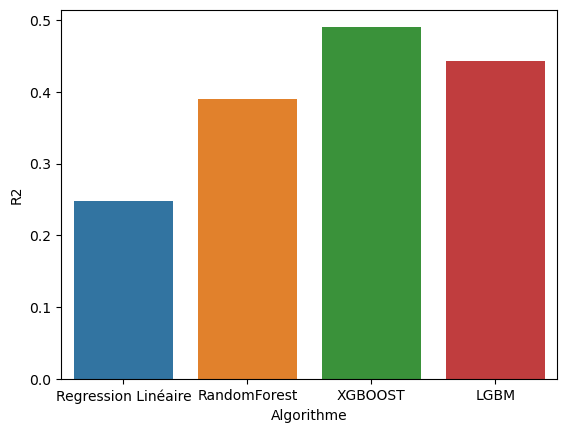

In [59]:
sns.barplot(data=tmp,x='Algorithme',y="R2")
plt.show()

In [60]:
tmp2 = pd.melt(tmp,id_vars='Algorithme')
tmp2

,Algorithme,variable,value
0,Regression Linéaire,R2,0.247494
1,RandomForest,R2,0.389897
2,XGBOOST,R2,0.489714
3,LGBM,R2,0.443412
4,Regression Linéaire,MSE,1.033429
5,RandomForest,MSE,0.784533
6,XGBOOST,MSE,0.674925
7,LGBM,MSE,0.763818


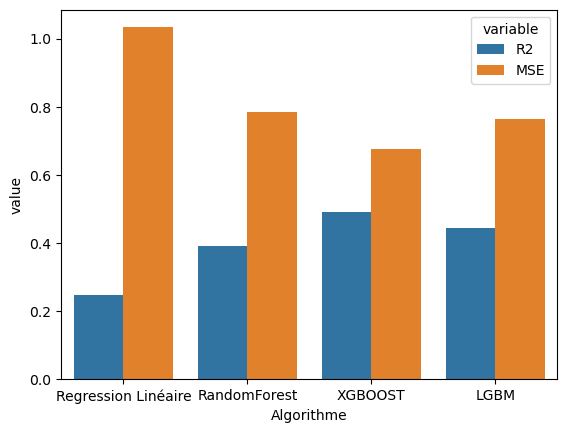

In [62]:
sns.barplot(data=tmp2, x='Algorithme',y='value',hue='variable')
plt.show()

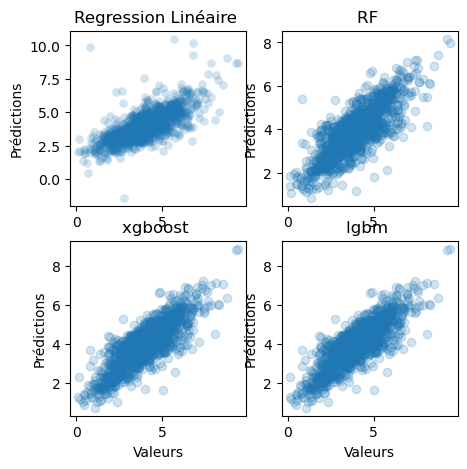

In [26]:
plt.figure(figsize=(5,5))

plt.subplot(2,2,1)

plt.scatter(res[0]['Valeurs'],res[0]['Prédictions'],alpha=0.2, linewidths = .1)
plt.title('Regression Linéaire ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,2)

plt.scatter(res[1]['Valeurs'],res[1]['Prédictions'],alpha=0.2)
plt.title('RF ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,3)

plt.scatter(res[2]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
plt.title('xgboost ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.subplot(2,2,4)

plt.scatter(res[3]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
#plt.plot(res[3]['Valeurs'],res[2]['Prédictions'])
plt.title('lgbm ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.show()



# Final XGB model

In [27]:
final_xgb =  xgb.XGBRegressor( max_depth=3, n_estimators=150,n_jobs= -1) 

In [28]:
final_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
pred_xgb = final_xgb.predict(X_test)

In [30]:
mean_squared_error(pred_xgb,y_test),r2_score(pred_xgb,y_test)

(0.7946796377438495, 0.39931381059885884)

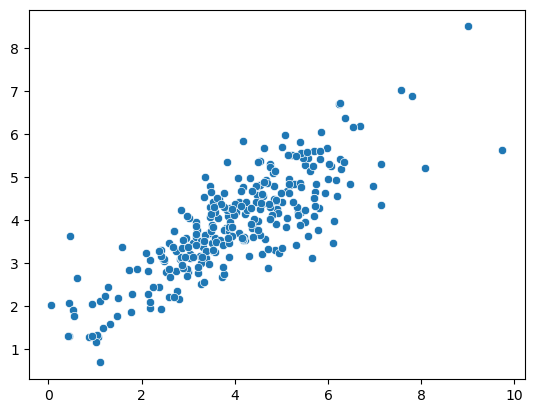

In [31]:
sns.scatterplot(x= y_test , y=pred_xgb)
plt.show()

# SHAP 

In [32]:
#conda install -c conda-forge shap

In [33]:
import shap 

In [34]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [35]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

## Shap Features Importances

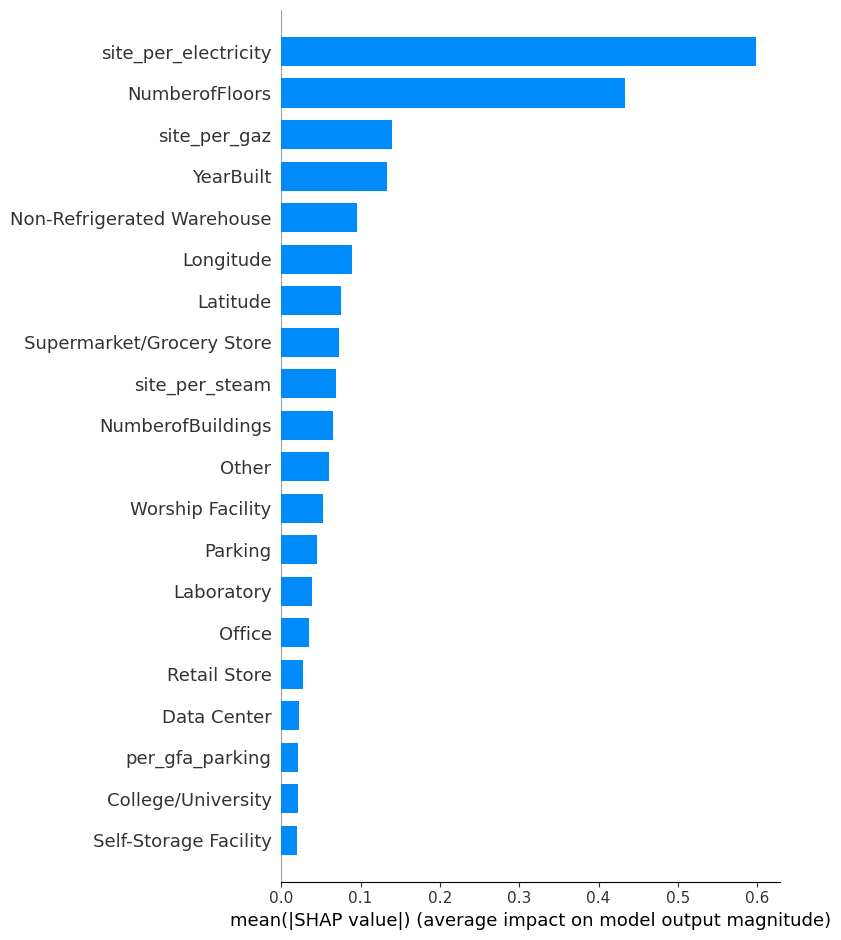

In [36]:
shap_values = shap.TreeExplainer(final_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=features_names)

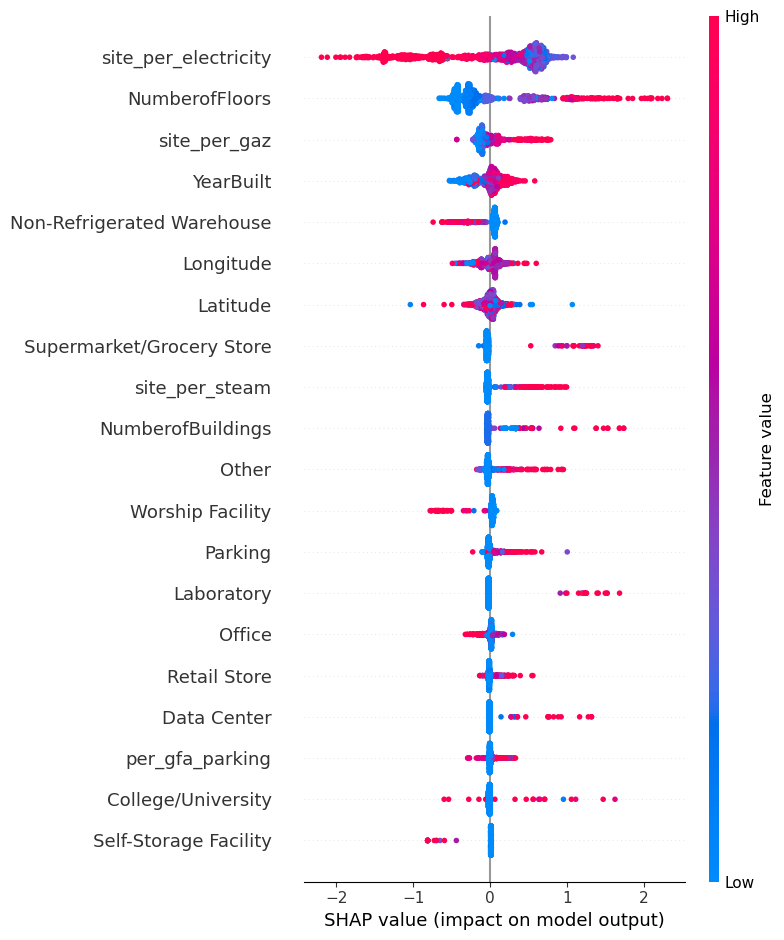

In [37]:
shap.summary_plot(shap_values, X_train,feature_names=features_names)

# Energy Star Score 
    On ajoute aux features X energy Star Score
    y demeure log TotalGHGEmission
    On test sur un train test notre meilleur modèle XGB avec les hyper paramètres selectionnés

## Features : variables prédictives 

In [64]:
# On supprime la cible à prédire et l'ID
X_Star_Score = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID']).copy()

# On supprime les Energy Star Score avec NA
X_Star_Score.dropna(subset = ['ENERGYSTARScore'],inplace=True) 
X_Star_Score.shape

(948, 41)

In [69]:
# On applique la même technique d'imputation pour les 2 lignes restantes que précédement sans Energy Star Score 
X_Star_Score = X_Star_Score.fillna(0) 
X_Star_Score.shape

(948, 41)

In [72]:
# On conserve un jeu de données de méme dimension sans la variable Energy Score pour les comparer les 2 datasets
X_No_Score = X_Star_Score.drop(columns = ['ENERGYSTARScore']).copy()
X_No_Score.shape

(948, 40)

In [76]:
# On transforme en Array les deux datasets
X_Star_Score, X_No_Score = np.array(X_Star_Score), np.array(X_No_Score)
X_Star_Score,X_No_Score

(array([[  47.6122 , -122.33799, 1927.     , ...,    0.     ,    0.     ,
            0.     ],
        [  47.61317, -122.33393, 1996.     , ...,    0.     ,    0.     ,
            0.     ],
        [  47.61393, -122.3381 , 1969.     , ...,    0.     ,    0.     ,
            0.     ],
        ...,
        [  47.54425, -122.31776, 1955.     , ...,    0.     ,    0.     ,
            0.     ],
        [  47.53161, -122.29944, 1929.     , ...,    0.     ,    0.     ,
            0.     ],
        [  47.58831, -122.3065 , 2015.     , ...,    0.     ,    0.     ,
            0.     ]]),
 array([[  47.6122 , -122.33799, 1927.     , ...,    0.     ,    0.     ,
            0.     ],
        [  47.61317, -122.33393, 1996.     , ...,    0.     ,    0.     ,
            0.     ],
        [  47.61393, -122.3381 , 1969.     , ...,    0.     ,    0.     ,
            0.     ],
        ...,
        [  47.54425, -122.31776, 1955.     , ...,    0.     ,    0.     ,
            0.     ],
        [  4

In [81]:
print(
    'Dimension de nos 2 échantillons ',
    '\n',
    '\n Lignes X_Star_Score : ',X_Star_Score.shape[0],
    '\n X_Star_Score Features : ',X_Star_Score.shape[1],
    '\n',
    '\n Lignes X_No_Score :',X_No_Score.shape[0],
    '\n X_No_Score Features : ', X_No_Score.shape[1]
     )

Dimension de nos 2 échantillons  
 
 Lignes X_Star_Score :  948 
 X_Star_Score Features :  41 
 
 Lignes X_No_Score : 948 
 X_No_Score Features :  40


## Target : valeur cible à prédire

In [82]:
y_Star_Score = db[['ENERGYSTARScore','log_TotalGHGEmissions']].copy()
y_Star_Score = y_Star_Score.dropna()
y_Star_Score = np.array(y_Star_Score)
print('Nb de lignes y_Star_Score à prédire : ',y_Star_Score.shape[0])

Nb de lignes y_Star_Score à prédire :  948


In [83]:
# cible y demeure la même 'y_Star_Score'
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_Star_Score, y_Star_Score, test_size=0.2 , random_state = 2023)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_No_Score, y_Star_Score, test_size=0.2 , random_state = 2023)

### On entraine nos deux modèles 

In [95]:
# 1er avec Energy Star Score 
final_xgb.fit(X_train_2,y_train_2) 
pred_star_score = final_xgb.predict(X_test_2)

In [96]:
# Le second sans Energy Star Score
final_xgb.fit(X_train_3,y_train_3)
pred_no_score = final_xgb.predict(X_test_3)

### On compare nos modèles 

In [97]:
print(
    'Avec Energy Star Score : \n',
    'MSE : ', mean_squared_error(pred_star_score,y_test_2),'\n',
    'R2 : ',r2_score(pred_star_score,y_test_2),
    '\n\n',
    'Sans Energy Star Score : \n',
    'MSE : ', mean_squared_error(pred_no_score,y_test_3),'\n',
    'R2 : ',r2_score(pred_no_score,y_test_3)

)

Avec Energy Star Score : 
 MSE :  0.37846189542120356 
 R2 :  0.8371669146503171 

 Sans Energy Star Score : 
 MSE :  443.1857102957552 
 R2 :  -1.173415213068067


### On constate de meilleurs prédictions avec la variable Ernergy Star Score

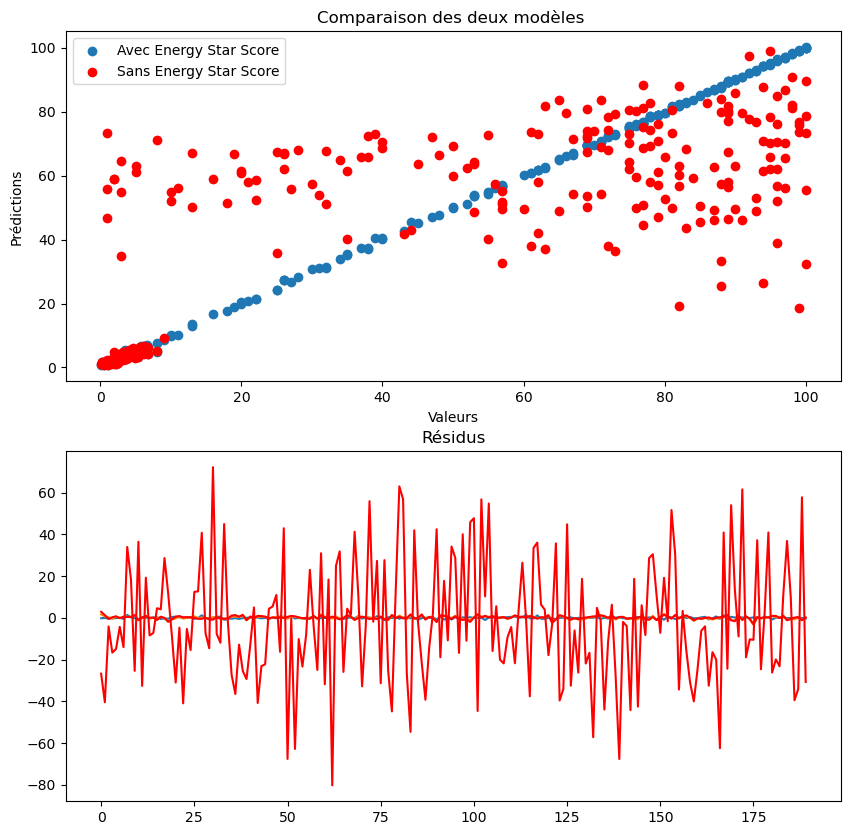

In [134]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)

plt.scatter(x= y_test_2 , y=pred_star_score,label='Avec Energy Star Score')
plt.scatter(x= y_test_3 , y=pred_no_score,color='r',label='Sans Energy Star Score')
plt.title('Comparaison des deux modèles ')
plt.xlabel('Valeurs')
plt.ylabel('Prédictions')
plt.legend()

plt.subplot(2,1,2)

plt.plot(pred_star_score-y_test_2,label='Avec Energy Star Score')
plt.plot(pred_no_score-y_test_3,color='r',label='Sans Energy Star Score')
plt.title('Résidus')

plt.show()

- Beaucoup mieux avec Energy Star Score 

# Prédiction uniquement avec une adresse postale ? 
    Scénario OpenClassrooms : Question de Douglas : Peut-on déduire des choses intérressantes d'une simple adresse ?
    - Prenons notre modèle final_xgb
    - entrainnons le sur X : var = Latitude et Longitude

In [135]:
db

,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,site_per_steam,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,0.277302,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,0.000000,...,0.000000,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,0.297113,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,0.325913,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,50221,47.54067,-122.37441,1982,1.0,1,0.000000,1.000000,0.678440,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1479,50223,47.59625,-122.32283,2004,1.0,1,0.000000,1.000000,0.417296,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1480,50224,47.63644,-122.35784,1974,1.0,1,0.000000,1.000000,0.310820,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1481,50225,47.52832,-122.32431,1989,1.0,1,0.000000,1.000000,0.484898,0.000000,...,0.034324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
db[['Latitude','Longitude']]

,Latitude,Longitude
0,47.61220,-122.33799
1,47.61317,-122.33393
2,47.61393,-122.33810
3,47.61412,-122.33664
4,47.61375,-122.34047
...,...,...
1478,47.54067,-122.37441
1479,47.59625,-122.32283
1480,47.63644,-122.35784
1481,47.52832,-122.32431


In [137]:
# On conserve cette fois ci les variables/features Latitude et Longitude
# y demeure inchangé
X_simple_address = db[['Latitude','Longitude']].copy() 
X_simple_address = np.array(X_simple_address)
X_simple_address

array([[  47.6122 , -122.33799],
       [  47.61317, -122.33393],
       [  47.61393, -122.3381 ],
       ...,
       [  47.63644, -122.35784],
       [  47.52832, -122.32431],
       [  47.53939, -122.29536]])

In [138]:
X_train_address, X_test_address, y_train_address, y_test_address = train_test_split(X_simple_address, y, test_size=0.2 , random_state = 2023)

In [139]:
final_xgb.fit(X_train_address,y_train_address)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [140]:
pred_simple_address = final_xgb.predict(X_test_address)

In [141]:
print('MSE : ', mean_squared_error(pred_simple_address,y_test_address),'\n',
      'R2 : ',r2_score(pred_simple_address,y_test_address))

MSE :  2.4254498910349653 
 R2 :  -2.148574779293607


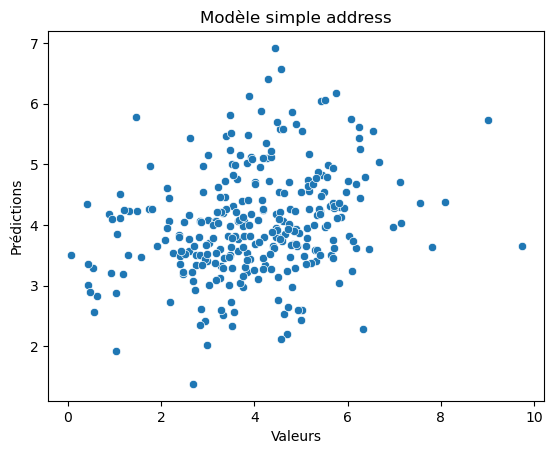

In [148]:
sns.scatterplot(x= y_test_address , y= pred_simple_address,lw=2)
plt.xlabel('Valeurs')
plt.ylabel('Prédictions')
plt.title('Modèle simple address')
plt.show()

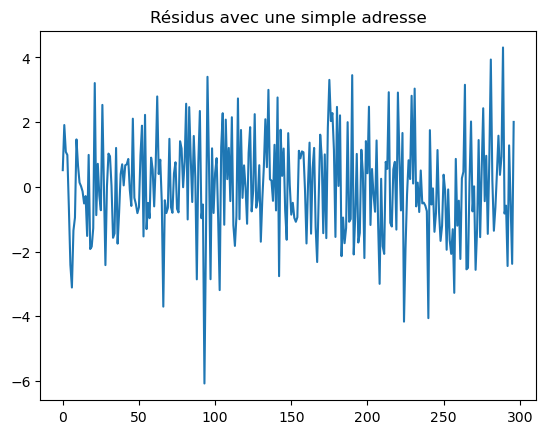

In [145]:
plt.plot(pred_simple_address-y_test_address)
plt.title('Résidus avec une simple adresse')
plt.show()

Résultat peu convaincant 